# **Pacual Capstone Group 4 Notebook - Route Optimization**

Group members: *Abdullah Alshaarawi, James Alarde, Hiromitsu Fujiyama, Sanjo Joy, Thomas Arturo Renwick Morales*

This notebook is organized in the following sections:

* [Part 0 - Importing the Necessary Libraries](#0)

* [Part 1 - Data Loading](#1)

* [Part 2 - Preliminary Data Analysis & Cleaning/Wrangling](#2)
  * [Part 2.1 - Preliminary Analysis of the Dataset](#2.1)
  * [Part 2.2 - Converting Column Names to Pythonic Snake-Case](#2.2)
  * [Part 2.3 - Dealing with Duplicates](#2.3)
  * [Part 2.4 - Ensuring Correct Data Types](#2.4)
  * [Part 2.5 - Dealing with Null/Missing Values](#2.5)
  * [Part 2.6 - Final Checks](#2.6)

* [Part 3 - Business Logic-Based Transformations](#3)
  * [Part 3.1 - Aligning `number_of_orders` to Business Definition of Delivery](#3.1)
  * [Part 3.2 - Exploring and Handling Non-Positive `income` Values](#3.2)
  * [Part 3.3 - Exploring and Handling Non-Positive `volume` Values](#3.3)

* [Part 4 - One Row per Client: Data Aggregation](#4)
  * [Part 4.1 - Validating Dataset Readiness for Aggregation](#4.1)
    * [Part 4.1.1 - Validation of `income` and `median_ticket` Integrity](#4.1.1)
    * [Part 4.1.2 - Verifying Consistent `city` and `channel` Assignment per Client](#4.1.2)
    * [Part 4.1.3 - Validation of Unique Promotor per Client](#4.1.3) 
    * [Part 4.1.4 -  Validation of Unique `prom_contacts_month` Assignments](#4.1.4)         
  * [Part 4.2 – Intermediary Step: Aggregating Client Data at a Monthly Level](#4.2)
  * [Part 4.3 – Final Client-Level Aggregation: One Row per Client](#4.3)

---

<a id='0'></a>
## Part 0 - Importing the Necessary Libraries

First, we imported the libraries which were necessary for our analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import numpy as np
import joblib

# Displaying only 2 decimal points for visual purposes
pd.set_option('display.float_format', '{:.2f}'.format) 

In [2]:
#To reset to default display option if needed later on:
## pd.reset_option('display.float_format')

<a id='1'></a>
# Part 1 - Data Loading

Then, we proceeded to load the dataset.

In [3]:
df = pd.read_csv('dataset/Orders_Master_Data(in).csv')

<a id='2'></a>
# Part 2 - Preliminary Data Analysis & Cleaning/Wrangling

<a id='2.1'></a>
## Part 2.1 - Preliminary Analysis of the Dataset

Before beginning with data cleaning/wrangling we ran basic pandas functions for preliminary analysis/view of the dataset.

In [4]:
df.head()

,Date,City,Channel,Client ID,Promotor ID,Volume,Income,Number of orders,Median Ticket (€),Prom Contacts Month,Tel Contacts Month
0,01.01.2024,Alicante,AR,398150871,729030652,5.94,0.00,1,0.00,0,0
1,01.01.2024,Alicante,HR,410234355,551409294,48.00,21.02,1,21.02,4,0
2,02.01.2024,Alicante,AR,123463493,551409294,125.25,92.57,1,92.57,1,0
3,02.01.2024,Alicante,AR,124527399,729030652,83.00,60.94,1,60.94,4,0
4,02.01.2024,Alicante,AR,130100821,729030652,768.00,244.33,1,244.33,1,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035735 entries, 0 to 1035734
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Date                 1035735 non-null  object 
 1   City                 1035735 non-null  object 
 2   Channel              1035735 non-null  object 
 3   Client ID            1035735 non-null  int64  
 4   Promotor ID          1035735 non-null  int64  
 5   Volume               1035735 non-null  float64
 6   Income               1035735 non-null  float64
 7   Number of orders     1035735 non-null  int64  
 8   Median Ticket (€)    1035735 non-null  float64
 9   Prom Contacts Month  1035735 non-null  int64  
 10  Tel Contacts Month   1035735 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 86.9+ MB


<a id='2.2'></a>
## Part 2.2 - Converting Column Names to Pythonic Snake-Case

Next, we converted column names to Pythonic snake-case as this would simplify the process of referencing them in code and maintaining consistency throughout the analysis.

In [6]:
df = df.rename(columns={'Date':'date', 
                        'City':'city', 
                        'Channel':'channel', 
                        'Client ID': 'client_id',
                        'Promotor ID': 'promotor_id',
                        'Volume': 'volume',
                        'Income': 'income',
                        'Number of orders': 'number_of_orders',
                        'Median Ticket (€)':'median_ticket',
                        'Prom Contacts Month': 'prom_contacts_month',
                        'Tel Contacts Month': 'tel_contacts_month'})

<a id='2.3'></a>
## Part 2.3 - Dealing with Duplicates

Then, we checked if there were duplicates, which was in fact the case.

In [7]:
df.duplicated().any()

True

We checked how many rows were duplicated out of the whole dataset and found there were quite a few.

In [8]:
# Total number of rows
total_rows = df.shape[0]

# Number of exact duplicates (all columns identical)
exact_duplicates = df.duplicated().sum()
print(f"Exact Duplicates: {exact_duplicates} out of {total_rows}")

Exact Duplicates: 20770 out of 1035735


We explored the duplicates, to check whether these were exact duplicates.

In [9]:
exact_duplicates = df[df.duplicated(keep=False)]
exact_duplicates.sort_values(by=['client_id', 'date']).head(10)

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
919356,11.03.2024,Tarragona,HR,100854769,306190165,54.30,117.02,1,117.02,4,0
1018754,11.03.2024,Tarragona,HR,100854769,306190165,54.30,117.02,1,117.02,4,0
917803,12.02.2024,Tarragona,HR,100854769,306190165,105.00,45.93,1,45.93,4,0
1017201,12.02.2024,Tarragona,HR,100854769,306190165,105.00,45.93,1,45.93,4,0
925032,13.06.2024,Tarragona,HR,100854769,306190165,45.20,90.50,1,90.50,4,0
1024430,13.06.2024,Tarragona,HR,100854769,306190165,45.20,90.50,1,90.50,4,0
930843,16.09.2024,Tarragona,HR,100854769,306190165,129.00,74.14,1,74.14,4,0
1030241,16.09.2024,Tarragona,HR,100854769,306190165,129.00,74.14,1,74.14,4,0
917063,29.01.2024,Tarragona,HR,100854769,306190165,105.00,45.93,1,45.93,4,0
1016461,29.01.2024,Tarragona,HR,100854769,306190165,105.00,45.93,1,45.93,4,0


As we found the duplicates were exact duplicates, we proceeded to drop the duplicated row, keeping the first occurrence to not lose any valuable data points.

In [10]:
df = df.drop_duplicates(keep='first')

We checked once more, to see if we had dealt with the duplicates properly and to observe if there were any remaining ones.

In [11]:
# Total number of rows
total_rows = df.shape[0]

# Number of exact duplicates (all columns identical)
exact_duplicates = df.duplicated().sum()
print(f"Exact Duplicates: {exact_duplicates} out of {total_rows}")

Exact Duplicates: 0 out of 1014965


As there were'nt any remaining duplicates (i.e., we had dealt with them properly), we proceeded to ensure the columns were in their correct/appropriate data type next.

<a id='2.4'></a>
## Part 2.4 - Ensuring Correct Data Types

After having had a preliminary view of the dataset, we determined that the columns should of of the following data types:
* `date`: datetime
* `city`: object
* `channel`: object	
* `client_id`: object
* `promotor_id` : object
* `volume`: float	
* `income`: float	
* `number_of_orders`: integer	
* `median_ticket`: float	
* `prom_contacts_month`: integer	
* `tel_contacts_month`: integer

Therefore we proceeded to check if the columns were in fact in the data types we wanted them to be.

In [12]:
df.dtypes

date                    object
city                    object
channel                 object
client_id                int64
promotor_id              int64
volume                 float64
income                 float64
number_of_orders         int64
median_ticket          float64
prom_contacts_month      int64
tel_contacts_month       int64
dtype: object

Most columns were already of the appropriate data type except for: `date`, `client_id`, and `promotor_id`. Therefore we proceeded to modify these into their appropriate data types.

In [13]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['client_id'] = df['client_id'].astype(str)
df['promotor_id'] = df['promotor_id'].astype(str)

We made a final check to make sure we had properly transformed these columns into their correct data type.

In [14]:
df.dtypes

date                   datetime64[ns]
city                           object
channel                        object
client_id                      object
promotor_id                    object
volume                        float64
income                        float64
number_of_orders                int64
median_ticket                 float64
prom_contacts_month             int64
tel_contacts_month              int64
dtype: object

Having all columns in the correct data type we proceeded to check for missing/null values in the dataset.

<a id='2.5'></a>
## Part 2.5 - Dealing with Null/Missing Values

In [15]:
df.isna().any()

date                   False
city                   False
channel                False
client_id              False
promotor_id            False
volume                 False
income                 False
number_of_orders       False
median_ticket          False
prom_contacts_month    False
tel_contacts_month     False
dtype: bool

In [16]:
df.isna().any().sum()

0

We found there were no missing/null values across the whole dataset.

Having completed this data wrangling step, we proceeded with final dataset checks to ensure consistency.

<a id='2.6'></a>
## Part 2.6 - Final checks

We had another prelimianry view of the data.

In [17]:
df.head()

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
0,2024-01-01,Alicante,AR,398150871,729030652,5.94,0.00,1,0.00,0,0
1,2024-01-01,Alicante,HR,410234355,551409294,48.00,21.02,1,21.02,4,0
2,2024-01-02,Alicante,AR,123463493,551409294,125.25,92.57,1,92.57,1,0
3,2024-01-02,Alicante,AR,124527399,729030652,83.00,60.94,1,60.94,4,0
4,2024-01-02,Alicante,AR,130100821,729030652,768.00,244.33,1,244.33,1,3


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1014965 entries, 0 to 1014964
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date                 1014965 non-null  datetime64[ns]
 1   city                 1014965 non-null  object        
 2   channel              1014965 non-null  object        
 3   client_id            1014965 non-null  object        
 4   promotor_id          1014965 non-null  object        
 5   volume               1014965 non-null  float64       
 6   income               1014965 non-null  float64       
 7   number_of_orders     1014965 non-null  int64         
 8   median_ticket        1014965 non-null  float64       
 9   prom_contacts_month  1014965 non-null  int64         
 10  tel_contacts_month   1014965 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 92.9+ MB


We checked for duplicates again.

In [19]:
df.duplicated().any()

False

We checked for data types again.

In [20]:
df.dtypes

date                   datetime64[ns]
city                           object
channel                        object
client_id                      object
promotor_id                    object
volume                        float64
income                        float64
number_of_orders                int64
median_ticket                 float64
prom_contacts_month             int64
tel_contacts_month              int64
dtype: object

Finally, we checked for any missing/null values again.

In [21]:
df.isna().any()

date                   False
city                   False
channel                False
client_id              False
promotor_id            False
volume                 False
income                 False
number_of_orders       False
median_ticket          False
prom_contacts_month    False
tel_contacts_month     False
dtype: bool

In [22]:
df.isna().any().sum()

0

With the data now clean and validated, we moved on to applying business logic transformations prior to client-level aggregation.

Just in case, we wrote to csv a copy of the cleaned dataset.

In [23]:
#df.to_csv('dataset/clean_orders_data/clean_orders_data.csv', index=False)

---

<a id='3'></a>
# Part 3 - Business Logic-Based Transformations

<a id='3.1'></a>
### Part 3.1 - Aligning `number_of_orders` to Business Definition of Delivery

Following a discussion with the Pascual team, it was clarified that each row in the dataset represents a single delivery, even in cases where multiple orders are recorded. Therefore, for all rows where the `number_of_orders` exceeded 1, the value was standardized to 1, in alignment with the business understanding that only the delivery itself, rather than the individual orders, is relevant for assessing logistical costs

In [24]:
df['number_of_orders'] = df['number_of_orders'].apply(lambda x: 1 if x > 1 else x)
df['number_of_orders'].value_counts()

number_of_orders
1    998928
0     16037
Name: count, dtype: int64

Having performed this transformation, we also found there were were approximately 16000 rows with `number_of_orders` equal to 0. We continued to explore these.

In [25]:
zero_orders_v1 = df[df['number_of_orders']==0]
zero_orders_v1

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
33,2024-01-02,Alicante,AR,697976135,39304770,0.00,-17.98,0,-17.98,0,0
64,2024-01-02,Alicante,HR,852243122,729030652,0.00,0.00,0,0.00,0,0
103,2024-01-03,Alicante,AR,702594377,218497097,0.00,0.00,0,0.00,0,0
140,2024-01-03,Alicante,HR,255446686,551409294,0.00,0.00,0,0.00,0,0
141,2024-01-03,Alicante,HR,266456261,551409294,0.00,0.00,0,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1014805,2024-12-31,Valencia,AR,661172837,327176535,0.00,0.00,0,0.00,0,0
1014881,2024-12-31,Valencia,HR,382663741,327176535,0.00,0.00,0,0.00,0,0
1014893,2024-12-31,Valencia,HR,449827392,307450899,0.00,1302.44,0,1302.44,0,0
1014915,2024-12-31,Valencia,HR,650595433,376164172,0.00,0.00,0,0.00,0,0


For rows that did not correspond to an order, did not generate any income, and lacked any relevant feature with a non-zero value were considered non-informative, we removed from the dataset.

In [26]:
columns_to_check = ['volume', 'income', 'number_of_orders', 'median_ticket']

# Drop rows where all the columns in columns_to_check are 0
df = df[~(df[columns_to_check] == 0).all(axis=1)]

After dropping those rows, we checked to see how many rows there were remaining with `number_of_orders` equal to 0.

In [27]:
df['number_of_orders'].value_counts()

number_of_orders
1    998928
0      3377
Name: count, dtype: int64

There were approximately 3000 remaining (much less than before). We continued to further explore these.

In [28]:
zero_orders_v2 = df[df['number_of_orders']==0]
zero_orders_v2

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
33,2024-01-02,Alicante,AR,697976135,39304770,0.00,-17.98,0,-17.98,0,0
289,2024-01-04,Alicante,HR,454699461,551409294,-1.20,-3.07,0,-3.07,0,0
376,2024-01-05,Alicante,HR,129590664,91937945,-3.50,-21.34,0,-21.34,0,0
441,2024-01-08,Alicante,AR,394499568,39304770,-10.20,-50.75,0,-50.75,0,0
991,2024-01-15,Alicante,HR,986671407,551409294,-2.34,-23.92,0,-23.92,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1012956,2024-12-17,Valencia,HR,527370739,327176535,-2.00,-46.90,0,-46.90,0,0
1013410,2024-12-19,Valencia,HR,468061603,444765134,-0.13,-24.60,0,-24.60,0,0
1014586,2024-12-30,Valencia,AR,496800310,460456701,0.00,-316.24,0,-316.24,0,0
1014685,2024-12-30,Valencia,HR,484045160,52875287,-7.68,-41.32,0,-41.32,0,0


In [29]:
zero_orders_v2[zero_orders_v2['income']<0]

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
33,2024-01-02,Alicante,AR,697976135,39304770,0.00,-17.98,0,-17.98,0,0
289,2024-01-04,Alicante,HR,454699461,551409294,-1.20,-3.07,0,-3.07,0,0
376,2024-01-05,Alicante,HR,129590664,91937945,-3.50,-21.34,0,-21.34,0,0
441,2024-01-08,Alicante,AR,394499568,39304770,-10.20,-50.75,0,-50.75,0,0
991,2024-01-15,Alicante,HR,986671407,551409294,-2.34,-23.92,0,-23.92,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1012470,2024-12-13,Valencia,AR,835982499,460456701,-90.00,-113.52,0,-113.52,0,0
1012956,2024-12-17,Valencia,HR,527370739,327176535,-2.00,-46.90,0,-46.90,0,0
1013410,2024-12-19,Valencia,HR,468061603,444765134,-0.13,-24.60,0,-24.60,0,0
1014586,2024-12-30,Valencia,AR,496800310,460456701,0.00,-316.24,0,-316.24,0,0


From the reduced dataset, after removing rows where all key values were zero, we identified a subset that represented reimbursements, as these entries showed negative income. Given that the core objective of the business problem is to optimize the number of contacts and orders, and to reduce delivery frequency for clients with low median tickets, reimbursements fall outside the scope of the analysis. As such, we excluded these rows. A similar approach was later applied to rows with positive values for `number_of_orders` that still did not align with the business logic, as documented further below in this notebook.

In [30]:
df = df[~((df['number_of_orders'] == 0) & (df['income'] < 0))]

Once again, we checked how many rows were remaining where the `number_of_orders` was equal to 0.

In [31]:
df['number_of_orders'].value_counts()

number_of_orders
1    998928
0       696
Name: count, dtype: int64

We had very few remaining, but still continued to analyse these as they could provide useful to our solution.

In [32]:
zero_orders_v3 = df[df['number_of_orders']==0]
zero_orders_v3

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
1069,2024-01-16,Alicante,HR,739047412,729030652,0.00,25.69,0,25.69,0,0
3284,2024-02-15,Alicante,HR,834091316,39304770,-0.12,1.79,0,1.79,2,0
5916,2024-03-22,Alicante,HR,242737368,91937945,0.00,247.83,0,247.83,1,1
6940,2024-04-05,Alicante,HR,626345680,729030652,0.00,3.62,0,3.62,4,0
8336,2024-04-25,Alicante,HR,428763364,465678196,0.00,6.56,0,6.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1006028,2024-10-31,Valencia,HR,449827392,307450899,0.00,2406.05,0,2406.05,0,0
1008966,2024-11-19,Valencia,HR,499147131,937854151,-5.90,105.10,0,105.10,0,4
1010532,2024-11-29,Valencia,HR,109091330,376164172,0.00,5.44,0,5.44,4,0
1010580,2024-11-29,Valencia,HR,449827392,307450899,0.00,120.95,0,60.48,0,0


In [33]:
print((len(zero_orders_v3)/len(df))*100)

0.06962617944347074


After careful consideration, we determined that the number of rows affected by this issue, combined with the inability to reliably match the associated income values to specific deliveries, did not justify their inclusion in our solution. Additionally, these rows accounted for only 0.06% of the entire dataset, representing a negligible impact on the overall analysis.

During the initial data exploration, we observed that rows with `number_of_orders equal` to 0 were introducing distortions, particularly in the assignment of `prom_contacts_month`. In many of these cases, the recorded value differed from the expected or set contact frequency, further reinforcing our decision to exclude all rows where `number_of_orders` equals 0.

In [34]:
df = df[~(df['number_of_orders'] == 0)]
df['number_of_orders'].value_counts()

number_of_orders
1    998928
Name: count, dtype: int64

<a id='3.2'></a>
### Part 3.2 - Exploring and Handling Non-Positive `income` Values

As previously explained, based on our meeting with the Pascual team, we learned that negative `income` values represent reimbursement transactions.

In [35]:
negative_income_df = df[df['income']<0]
negative_income_df

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
144,2024-01-03,Alicante,HR,310637681,91937945,-103.99,-60.90,1,-30.45,0,0
2021,2024-01-30,Alicante,AR,912139581,91937945,0.00,-0.31,1,-0.15,0,0
4053,2024-02-27,Alicante,HR,557261162,39304770,12.00,-745.01,1,-248.34,0,0
5928,2024-03-22,Alicante,HR,392868386,729030652,1.00,-35.37,1,-35.37,0,0
6319,2024-03-27,Alicante,HR,867912400,91937945,0.00,-21.12,1,-10.56,0,0
...,...,...,...,...,...,...,...,...,...,...,...
994639,2024-08-21,Valencia,AR,392518446,444765134,0.00,-2.62,1,-1.31,0,0
1001565,2024-10-03,Valencia,HR,371882962,249555220,108.00,-73.52,1,-73.52,0,0
1008398,2024-11-14,Valencia,HR,796836014,376164172,1.00,-0.52,1,-0.52,0,0
1009697,2024-11-25,Valencia,AR,859513033,249555220,-138.20,-105.35,1,-52.67,0,0


In [36]:
print((len(negative_income_df)/len(df))*100)

0.036238848045104355


Since these entries represented reimbursements (and therefore did not correspond to any actual order, contact, or delivery), they fell outside the scope of our analysis, which is centered on optimizing the number of orders, contacts, and delivery frequency. Furthermore, as these reimbursement rows accounted for only 0.03% of the entire dataset, we determined that excluding them would not have a significant impact on the results, and thus decided to drop them from the analysis.

In [37]:
df = df[~(df['income'] < 0)]

As a quick validation step, we confirmed that no negative values remained in either the `income` or `median_ticket columns`. This was expected, as removing rows with negative `income` values would inherently eliminate all instances with negative `median_ticket` values as well.

In [38]:
df[df['income']<0]

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month


In [39]:
df[df['median_ticket']<0]

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month


Next, we analyzed the rows with zero `income`. Based on our discussion with the Pascual team, we learned that the cases where `income` is zero but `volume` is positive (and viceversa), occur when a client places an order for a product that is temporarily unavailable and thus delivered at a later date. Consequently, retaining these rows during aggregation is valuable, as it ensures that total income and volume remain consistent, even if there is a temporal mismatch between the delivery date and the date when the income is recorded.

In [40]:
zero_income_df = df[df['income'] == 0]
zero_income_df

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
0,2024-01-01,Alicante,AR,398150871,729030652,5.94,0.00,1,0.00,0,0
476,2024-01-08,Alicante,HR,192636072,551409294,2.00,0.00,1,0.00,0,0
764,2024-01-11,Alicante,AR,849686805,91937945,54.00,0.00,1,0.00,0,0
992,2024-01-15,Alicante,HR,997226856,729030652,18.00,0.00,1,0.00,0,0
1042,2024-01-16,Alicante,HR,305165033,39304770,6.00,0.00,1,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1013027,2024-12-17,Valencia,HR,984571651,376164172,10.50,0.00,1,0.00,0,0
1013236,2024-12-18,Valencia,HR,867929828,937854151,160.00,0.00,1,0.00,0,0
1013386,2024-12-19,Valencia,HR,289098760,998162842,63.36,0.00,1,0.00,0,0
1014159,2024-12-26,Valencia,AR,523185829,937854151,0.00,0.00,1,0.00,0,0


In [41]:
zero_income_df[zero_income_df['volume']>0]

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
0,2024-01-01,Alicante,AR,398150871,729030652,5.94,0.00,1,0.00,0,0
476,2024-01-08,Alicante,HR,192636072,551409294,2.00,0.00,1,0.00,0,0
764,2024-01-11,Alicante,AR,849686805,91937945,54.00,0.00,1,0.00,0,0
992,2024-01-15,Alicante,HR,997226856,729030652,18.00,0.00,1,0.00,0,0
1042,2024-01-16,Alicante,HR,305165033,39304770,6.00,0.00,1,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1012161,2024-12-11,Valencia,HR,769959098,327176535,10.00,0.00,1,0.00,0,0
1013027,2024-12-17,Valencia,HR,984571651,376164172,10.50,0.00,1,0.00,0,0
1013236,2024-12-18,Valencia,HR,867929828,937854151,160.00,0.00,1,0.00,0,0
1013386,2024-12-19,Valencia,HR,289098760,998162842,63.36,0.00,1,0.00,0,0


We discarded rows with `number_of_orders` equal to 1 but lacking values for `income`, `median_ticket`, and `volume`, as they did not appear to represent any meaningful transaction or delivery.

In [42]:
columns_to_check = ['volume', 'income', 'median_ticket']

# Drop rows where all the columns in columns_to_check are 0
df = df[~(df[columns_to_check] == 0).all(axis=1)]

In [43]:
df[(df['income']==0) & (df['volume']>0)]

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
0,2024-01-01,Alicante,AR,398150871,729030652,5.94,0.00,1,0.00,0,0
476,2024-01-08,Alicante,HR,192636072,551409294,2.00,0.00,1,0.00,0,0
764,2024-01-11,Alicante,AR,849686805,91937945,54.00,0.00,1,0.00,0,0
992,2024-01-15,Alicante,HR,997226856,729030652,18.00,0.00,1,0.00,0,0
1042,2024-01-16,Alicante,HR,305165033,39304770,6.00,0.00,1,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1012161,2024-12-11,Valencia,HR,769959098,327176535,10.00,0.00,1,0.00,0,0
1013027,2024-12-17,Valencia,HR,984571651,376164172,10.50,0.00,1,0.00,0,0
1013236,2024-12-18,Valencia,HR,867929828,937854151,160.00,0.00,1,0.00,0,0
1013386,2024-12-19,Valencia,HR,289098760,998162842,63.36,0.00,1,0.00,0,0


With these steps completed, we proceeded to analyze the volume column.

<a id='3.3'></a>
### Part 3.3 - Exploring and Handling Non-Positive `volume` Values

First, we decided to explore values for which `volume` was negative.

In [44]:
negative_vols_df = df[df['volume']<0]
negative_vols_df

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
11615,2024-06-06,Alicante,HR,743069430,91937945,-66.00,49.01,1,24.50,4,0
54375,2024-12-12,Almeria,HR,868637556,525968071,-3.20,22.14,1,11.07,4,0
102163,2024-01-29,Barcelona,AR,210251406,370050701,-32.48,100.12,1,50.06,4,0
166641,2024-05-21,Barcelona,HR,565381694,977036215,-2.35,34.08,1,17.04,4,0
206066,2024-07-29,Barcelona,AR,464747253,187031601,-27.45,10.93,1,5.46,2,1
213140,2024-08-12,Barcelona,AR,867389663,313095800,-207.12,69.18,1,69.18,2,0
476660,2024-01-18,Madrid,HR,345327306,244328661,-26.55,37.14,1,18.57,8,0
572467,2024-05-23,Madrid,HR,722172852,268093511,-0.62,12.29,1,12.29,4,0
582488,2024-06-05,Madrid,HR,328649304,940421758,-39.00,119.63,1,119.63,4,0
761896,2024-08-06,Malaga,AR,848887318,385906115,-132.00,1.20,1,0.60,2,2


In [45]:
len(negative_vols_df)

15

In [46]:
print((len(negative_vols_df)/len(df))*100)

0.0015028780113918153


We identified 15 rows with negative volume values. Following our discussion with the Pascual team, it was confirmed that there is no valid business scenario in which volume can be negative while income remains positive. Since these rows accounted for only 0.0015% of the entire dataset, we decided to exclude them from the analysis.

As previously discussed, rows with `volume` equal to 0 but a positive income (and viceversa) typically correspond to cases where an order could not be fulfilled on a given day and was delivered at a later date. These entries represent advance payments made by customers for temporarily unavailable products. Given their relevance for maintaining consistency between `income` and `volume` when aggregating, we retained these rows in the analysis.

In [47]:
zero_vol_df = df[df['volume']==0]
zero_vol_df

,date,city,channel,client_id,promotor_id,volume,income,number_of_orders,median_ticket,prom_contacts_month,tel_contacts_month
29040,2024-02-02,Almeria,AR,813049802,937805441,0.00,2.36,1,1.18,4,0
55599,2024-12-30,Almeria,AR,795908727,902429632,0.00,21.06,1,10.53,4,0
90287,2024-01-08,Barcelona,AR,178242783,370050701,0.00,36.03,1,18.02,4,0
418548,2024-01-02,Islas Baleares,AR,584774454,465693592,0.00,0.01,1,0.01,1,1
419656,2024-01-11,Islas Baleares,AR,578959009,469564819,0.00,0.01,1,0.01,1,1
420984,2024-01-24,Islas Baleares,HR,407305159,465693592,0.00,0.01,1,0.00,1,0
425268,2024-02-29,Islas Baleares,HR,381638749,465693592,0.00,14.32,1,7.16,1,0
425442,2024-03-04,Islas Baleares,HR,516410361,469564819,0.00,0.48,1,0.24,0,0
427574,2024-03-20,Islas Baleares,AR,722128852,469564819,0.00,0.01,1,0.01,2,0
427992,2024-03-22,Islas Baleares,AR,654014436,221686221,0.00,0.01,1,0.01,0,0


<a id='4'></a>
## Part 4 – One Row per Client: Data Aggregation

<a id='4.1'></a>
### Part 4.1 - Validating Dataset Readiness for Aggregation

In order to aggregate the data to a single row per client, as requested by the company, it was first necessary to perform final validation checks to ensure the dataset was ready for aggregation.

<a id='4.1.1'></a>
#### Part 4.1.1 – Validation of `income` and `median_ticket` Integrity

First, we ensured that no client had a negative total income for the entire year. During the initial exploratory data analysis, some clients appeared to have negative total income. However, this was due to the presence of reimbursements, which had not yet been considered. After identifying these reimbursements and applying the business logic to exclude them (since they do not contribute meaningfully to the project's final objective), we were able to confirm that no clients had a negative total income for the year 2024.

In [48]:
#Summing total income across all entries by client
total_income = df.groupby('client_id')['income'].sum().sort_values()

#Creating a series which shows just negative total income (from most negative to least)
negative_income_clients = total_income[total_income < 0]

negative_income_clients.sort_values()

Series([], Name: income, dtype: float64)

We also verified the same condition for the median ticket, confirming that no clients had a negative median ticket value.

In [49]:
#Summing total income across all entries by client
median_ticket = df.groupby('client_id')['median_ticket'].median().sort_values()

#Creating a series which shows just negative total income (from most negative to least)
negative_median_ticket_clients = median_ticket[median_ticket < 0]

negative_median_ticket_clients.sort_values()

Series([], Name: median_ticket, dtype: float64)

<a id='4.1.2'></a>
#### Part 4.1.2 – Verifying Consistent `city` and `channel` Assignment per Client

Next, in order to aggregate clients by `city` and `channel`, by retaining only the first occurrence of each for every client, we needed to ensure that each client was consistently associated with a single `city` and `channel` throughout the dataset. Upon verification, we confirmed that this condition was met: each `client_id` corresponded uniquely to one `city` and one channel. This allowed us to proceed confidently with the intended aggregation strategy.

In [50]:
# Validating that 'channel' and 'city' are unique per client
multi_channel = df.groupby('client_id')['channel'].nunique()
print("Clients with >1 unique channel:", (multi_channel > 1).sum())

multi_city = df.groupby('client_id')['city'].nunique()
print("Clients with >1 unique city:", (multi_city > 1).sum())

Clients with >1 unique channel: 0
Clients with >1 unique city: 0


<a id='4.1.3'></a>
#### Part 4.1.3 – Validation of Unique Promotor per Client

Although the `promotor_id` variable was not essential for achieving the project’s main objective, we decided to validate its consistency in case it could be useful in future analysis. Specifically, we checked whether each client was consistently assigned a single promotor across the entire dataset. This would allow us to safely include `promotor_id` during aggregation, similarly to how we handled `city` and `channel`, by retaining only the first occurrence per client.

In [51]:
# Check if each promotor id is unqiue to a client 
# Group by client and count the number of unique promotors per client
promotors_per_client = df.groupby('client_id')['promotor_id'].nunique()

# Filter clients who have more than one unique promotor
clients_with_multiple_promotors = promotors_per_client[promotors_per_client > 1]

# Print result
if clients_with_multiple_promotors.empty:
    print("✅ Each client has only one unique promotor_id assigned.")
else:
    print("❌ Some clients have more than one promotor_id assigned.")
    print(clients_with_multiple_promotors)

✅ Each client has only one unique promotor_id assigned.


We confirmed that each client was assigned a unique `promotor_id` throughout the dataset. This consistency meant that it was be possible to include `promotor_id` in the aggregation process.

<a id='4.1.4'></a>
#### Part 4.1.4 – Validation of Unique `prom_contacts_month` Assignments

Another important validation step was to ensure that each client had a consistent number of monthly promotional visits/contacts (`prom_contacts_month`) across the dataset. During the initial data exploration, we observed that certain rows, particularly those with zero values in key variables such as `number_of_orders`, `income`, `volume`, or `median_ticket`, were distorting the `prom_contacts_month` values. In many of these cases, clients were assigned a `prom_contacts_month` value different from their pre-established/expected KPI. As a result, we proceeded to verify whether each client had a single, consistent `prom_contacts_month` value assigned to them.

In [52]:
# Group by client_id and count unique values of prom_contacts_month
prom_contact_variability = df.groupby('client_id')['prom_contacts_month'].nunique().reset_index()
prom_contact_variability.columns = ['client_id', 'unique_prom_contacts_values']

# Filter clients with more than one unique value
inconsistent_clients = prom_contact_variability[prom_contact_variability['unique_prom_contacts_values'] > 1]

print("Number of clients with inconsistent prom_contacts_month:", inconsistent_clients.shape[0])
print("List of clients with inconsistencies:")
print(inconsistent_clients)

Number of clients with inconsistent prom_contacts_month: 1188
List of clients with inconsistencies:
       client_id  unique_prom_contacts_values
90     101732413                            2
147    102672550                            2
163    103024993                            2
247    104860782                            2
267    105262046                            2
...          ...                          ...
41739  997526233                            2
41751  997838238                            2
41796  998571152                            2
41826  999102515                            2
41869  999941988                            2

[1188 rows x 2 columns]


In [53]:
inconsistent_clients['unique_prom_contacts_values'].value_counts()

unique_prom_contacts_values
2    1188
Name: count, dtype: int64

We identified 1188 clients who had more than one distinct value assigned to the `prom_contacts_month` variable. All clients with inconsistent values for the number of promotional contacts/visits were found to have exactly two unique values for this feature. After consulting with the Pascual team, we were informed that this should not occur, as the number of monthly promotional contacts is a predefined KPI and should remain constant for each client. Based on this, we further investigated whether the secondary value observed in these cases was consistently zero. If this was confirmed, our approach would be to replace the zero values with the corresponding non-zero value assigned to each client, thereby restoring consistency in line with the business logic. 

In [54]:
# Identifying clients who had more than one unique value for prom_contacts_month
clients_with_2_values = df.groupby('client_id')['prom_contacts_month'].nunique()
clients_with_2_values = clients_with_2_values[clients_with_2_values > 1].index

# Checking if all these clients had 0 as one of their values
has_only_0_and_one_other = True

for client in clients_with_2_values:
    values = df[df['client_id'] == client]['prom_contacts_month'].unique()
    if 0 not in values:
        print(f"⚠️ Client {client} does NOT have 0 as one of the values. Values: {values}")
        has_only_0_and_one_other = False

if has_only_0_and_one_other:
    print("✅ All clients with 2 values have 0 as one of them.")
else:
    print("❌ Some clients have 2 values, but one of them is not 0.")

✅ All clients with 2 values have 0 as one of them.


Our analysis confirmed that, for every client with more than one value for `prom_contacts_month`, the non-assigned value was always zero. Based on this finding, we proceeded to replace all zero values with the corresponding non-zero value specific to each client. This ensured that the `prom_contacts_month` field remained consistent across the entire dataset for every client.

In [55]:
# For each client with inconsistent values, identifying the correct (non-zero) prom_contacts_month value
client_correct_value = {}

for client in clients_with_2_values:
    values = df[df['client_id'] == client]['prom_contacts_month'].unique()
    non_zero_value = [v for v in values if v != 0][0]  # the correct value
    client_correct_value[client] = non_zero_value

# Defining a function to replace 0s with the correct value for each client
def replace_zero_with_correct(row):
    if row['client_id'] in client_correct_value and row['prom_contacts_month'] == 0:
        return client_correct_value[row['client_id']]
    return row['prom_contacts_month']

# Applying the function
df['prom_contacts_month'] = df.apply(replace_zero_with_correct, axis=1)

Finally, we verified that each client had a single, consistent `prom_contacts_month` value across the entire dataset. This condition was met for all clients, confirming the consistency of this variable after the adjustments

In [56]:
prom_contact_variability = df.groupby('client_id')['prom_contacts_month'].nunique().reset_index()
prom_contact_variability.columns = ['client_id', 'unique_prom_contacts_values']

# Filter clients with more than one unique value
inconsistent_clients = prom_contact_variability[prom_contact_variability['unique_prom_contacts_values'] > 1]

print("Number of clients with inconsistent prom_contacts_month:", inconsistent_clients.shape[0])
print("List of clients with inconsistencies:")
print(inconsistent_clients)

Number of clients with inconsistent prom_contacts_month: 0
List of clients with inconsistencies:
Empty DataFrame
Columns: [client_id, unique_prom_contacts_values]
Index: []


Finally, once we ensured that all clients had a unique `prom_contacts_month` value assigned, we analyzed the distribution of these values across clients. We observed that a small subset of clients had a value of zero for `prom_contacts_month`. Interestingly, this included some high-value clients, such as the one generating the highest total income.

After consulting with the Pascual team, we learned that all clients should indeed have a predefined number of monthly promotional visits. In these specific cases, it is likely that the number of contacts was not set by Pascual but instead proposed by the client, indicating a more flexible or exceptional arrangement. This does not represent a data quality issue, but rather a limitation in the recording of this variable. A `prom_contacts_mont`h value of zero does not necessarily mean the client did not receive any visits; instead, it reflects that the value was unknown or not updated in the master dataset at the time.

While we could not determine the exact number of assigned visits in such cases, we took this into consideration during the optimization phase. Specifically, we proposed adjusted contact frequencies for these clients based on their ordering behavior and overall performance, in line with the project’s objective to improve efficiency while preserving service quality.

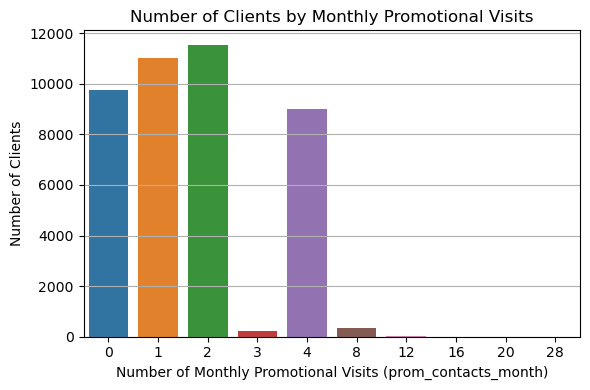

In [57]:
client_prom_contacts = df.groupby('client_id')['prom_contacts_month'].first()
distribution = client_prom_contacts.value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title("Number of Clients by Monthly Promotional Visits")
plt.xlabel("Number of Monthly Promotional Visits (prom_contacts_month)")
plt.ylabel("Number of Clients")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [58]:
highest_income_client = df.groupby('client_id')['income'].sum().sort_values(ascending=False).index[0]
print(f"The client with the highest total income is client_id = {highest_income_client}")
highest_income_client_df = df[df['client_id']==highest_income_client]
highest_income_client_df['prom_contacts_month'].value_counts()

The client with the highest total income is client_id = 386121207


prom_contacts_month
0    29
Name: count, dtype: int64

After verifying that no client had a negative total `income`, that each client was uniquely associated with a single `city`, `channel`, and promotor (`promotor_id`) and that each client had a consistent `prom_contacts_month` value for the year 2024 (as this is a predefined KPI), we proceeded to aggregate the dataset so that each client is represented by a single row.

**Note**: We decided not to retain `tel_contacts_month` in the final analysis, as this type of contact was not the primary focus of the problem. Additionally, it presented a different pattern of inconsistencies compared to `prom_contacts_month`, specifically, not all secondary values were equal to 0. This made it difficult to determine which value represented the originally assigned KPI, and thus, we could not confidently resolve the discrepancies.

<a id='4.2'></a>
### Part 4.2 – Intermediary Step: Aggregating Client Data at a Monthly Level

Before aggregating the data on a monthly basis, we first created a new column to extract the month from each date entry. This allowed us to generate a monthly aggregated table, which served as a logical intermediary step before proceeding to construct the final client-level table, where each client is represented by a single row.

In [59]:
df['month'] = df['date'].dt.to_period('M')

In [60]:
# Monthly aggregated table
monthly_df = df.groupby(['client_id', 'month']).agg({'city':'first',
                                              'channel':'first',
                                              'promotor_id':'first',
                                              'volume':'sum',
                                              'income':'sum',
                                              'number_of_orders':'sum',
                                              'median_ticket':'median', 
                                              'prom_contacts_month': 'first',
                                              'tel_contacts_month': 'first'})

monthly_df

city channel promotor_id  volume  income  \
client_id month                                                    
100006690 2024-01     Madrid      AR   275609911  202.50  203.99   
          2024-02     Madrid      AR   275609911  195.12  160.66   
          2024-03     Madrid      AR   275609911  138.53  111.39   
          2024-04     Madrid      AR   275609911  156.67  184.01   
          2024-05     Madrid      AR   275609911  175.29  172.16   
...                      ...     ...         ...     ...     ...   
999976985 2024-07  Barcelona      HR   996963848  270.00 1024.60   
          2024-08  Barcelona      HR   996963848  291.00 1217.87   
          2024-09  Barcelona      HR   996963848   78.00  240.43   
          2024-10  Barcelona      HR   996963848  209.00  806.33   
          2024-11  Barcelona      HR   996963848   63.00  203.67   

                   number_of_orders  median_ticket  prom_contacts_month  \
client_id month                                                           
100006690 2024-01                 2         102.00                    2   
          2024-02                 2          80.33                    2   
          2024-03                 2          55.70                    2   
          2024-04                 3          54.37                    2   
          2024-05                 3          59.78                    2   
...                             ...            ...                  ...   
999976985 2024-07                 3         227.80                    1   
          2024-08                 4         300.48                    1   
          2024-09                 1         240.43                    1   
          2024-10                 3         211.83                    1   
          2024-11                 2         101.83                    1   

                   tel_contacts_month  
client_id month                        
100006690 2024-01                   0  
          2024-02                   0  
          2024-03                   0  
          2024-04                   0  
          2024-05                   0  
...                               ...  
999976985 2024-07                   0  
          2024-08                   0  
          2024-09                   0  
          2024-10                   0  
          2024-11                   0  

[359844 rows x 9 columns]

<a id='4.3'></a>
### Part 4.3 – Final Client-Level Aggregation: One Row per Client

Finally, using the monthly aggregated table as a basis, we constructed the fully aggregated dataset, resulting in one row per client. Within this fully aggregated table, we created new features such as :

* **`frequency`**:
  The median number of monthly orders per client, calculated from the monthly aggregation. This provides insight into the regularity of a client's purchasing behavior over the year.

* **`efficiency`**:
  Defined as the total number of yearly orders divided by the total number of promotional contacts. The total contacts are estimated as `prom_contacts_month × 12`. This metric reflects how efficiently promoter visits are being converted into actual orders.

* **`logistics_cost`**:
  Estimated yearly cost associated with delivering the orders. Calculated as `number of yearly orders × €10`, based on the stated fixed delivery cost per order.

* **`visit_cost`**:
  Total yearly cost of promotional visits. Calculated as `prom_contacts_month × 12 × €15`, assuming one visit per month per KPI and a cost of €15 per visit.

* **`total_cost`**:
  The sum of logistics and visit costs, representing the total estimated yearly operational cost for each client.

In [61]:
#Fully aggregated table --> one row per client id, at a yearly level (missing extra features)

yearly_df = monthly_df.groupby('client_id').agg(
    city=('city', 'first'),
    channel=('channel', 'first'),
    promotor_id=('promotor_id', 'first'),
    volume=('volume', 'sum'),
    income=('income', 'sum'),
    number_of_orders=('number_of_orders', 'sum'),
    median_ticket=('median_ticket', 'median'),
    prom_contacts_month=('prom_contacts_month', 'first'),
    #tel_contacts_month=('tel_contacts_month', 'first'),
    frequency=('number_of_orders', 'median')
).reset_index()

#renaming columns which are yearly columns
yearly_df.rename(columns={'volume': 'yearly_volume',
                          'income': 'yearly_income',
                          'number_of_orders':'yearly_number_of_orders'},
                          inplace=True)

#Creating the new features --> as specified above in markdown
yearly_df['efficiency'] = yearly_df['prom_contacts_month']*12 / yearly_df['yearly_number_of_orders']
yearly_df['logistics_cost'] = yearly_df['yearly_number_of_orders']*10
yearly_df['visit_cost'] = yearly_df['prom_contacts_month'] *12 *15
yearly_df['total_cost'] = yearly_df['logistics_cost'] + yearly_df['visit_cost']

#displaying output
yearly_df

,client_id,city,channel,promotor_id,yearly_volume,yearly_income,yearly_number_of_orders,median_ticket,prom_contacts_month,frequency,efficiency,logistics_cost,visit_cost,total_cost
0,100006690,Madrid,AR,275609911,1658.71,1494.53,22,60.40,2,2.00,1.09,220,360,580
1,100008050,Barcelona,AR,368568690,3982.00,1905.59,14,132.37,0,1.00,0.00,140,0,140
2,100042162,Barcelona,HR,455263770,1812.85,2243.30,14,128.78,4,1.00,3.43,140,720,860
3,100046227,Barcelona,AR,454554895,4590.18,2273.12,16,129.06,2,4.00,1.50,160,360,520
4,100125158,Cádiz,HR,483340469,1266.50,2204.24,25,87.58,1,3.00,0.48,250,180,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41866,999934164,Barcelona,HR,480416490,691.00,785.30,23,38.22,1,2.00,0.52,230,180,410
41867,999940211,Barcelona,AR,908993212,557.82,260.55,3,76.43,0,1.00,0.00,30,0,30
41868,999940578,Madrid,AR,275609911,1101.52,1044.61,13,70.44,2,1.00,1.85,130,360,490
41869,999941988,Madrid,AR,677360818,5415.15,3828.31,36,108.86,2,3.00,0.67,360,360,720


In [62]:
#yearly_df.to_csv('yearly_df.csv')

# part 5. Customer Segmentation

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


 Select Features for PCA
We'll exclude identifiers and categorical fields:

In [64]:
features = [
    'yearly_volume',
    'yearly_income',
    'yearly_number_of_orders',
    'median_ticket',
    'prom_contacts_month',
    'frequency',
    'efficiency',
    'logistics_cost',
    'visit_cost',
    'total_cost'
]

X = yearly_df[features].copy()

 Standardize the Features

In [65]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [66]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

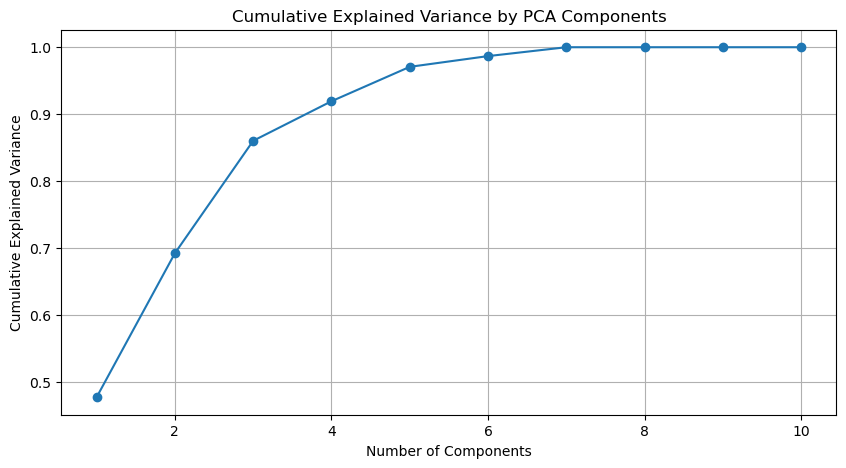

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(features)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [75]:
# === PCA (3 Components) ===
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

for i in range(3):
    yearly_df.loc[X.dropna().index, f'PCA{i+1}'] = X_pca[:, i]

# ===  KMeans Clustering ===
kmeans = KMeans(n_clusters=4, random_state=30)
yearly_df.loc[X.dropna().index, 'cluster'] = kmeans.fit_predict(X_pca)

In [76]:
# Show PCA component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=['PCA1', 'PCA2', 'PCA3']
)

# Show explained variance
explained_variance = pd.DataFrame({
    'PCA Component': ['PCA1', 'PCA2', 'PCA3'],
    'Explained Variance (%)': np.round(pca.explained_variance_ratio_ * 100, 2)
})

print("PCA Loadings:\n", loadings)
print("\nExplained Variance:\n", explained_variance)

PCA Loadings:
                          PCA1  PCA2  PCA3
yearly_volume            0.18  0.46  0.31
yearly_income            0.26  0.46  0.27
yearly_number_of_orders  0.40  0.08 -0.31
median_ticket            0.11  0.40  0.38
prom_contacts_month      0.33 -0.37  0.28
frequency                0.39  0.04 -0.25
efficiency              -0.05 -0.29  0.51
logistics_cost           0.40  0.08 -0.31
visit_cost               0.33 -0.37  0.28
total_cost               0.43 -0.22  0.05

Explained Variance:
   PCA Component  Explained Variance (%)
0          PCA1                   47.72
1          PCA2                   21.51
2          PCA3                   16.80


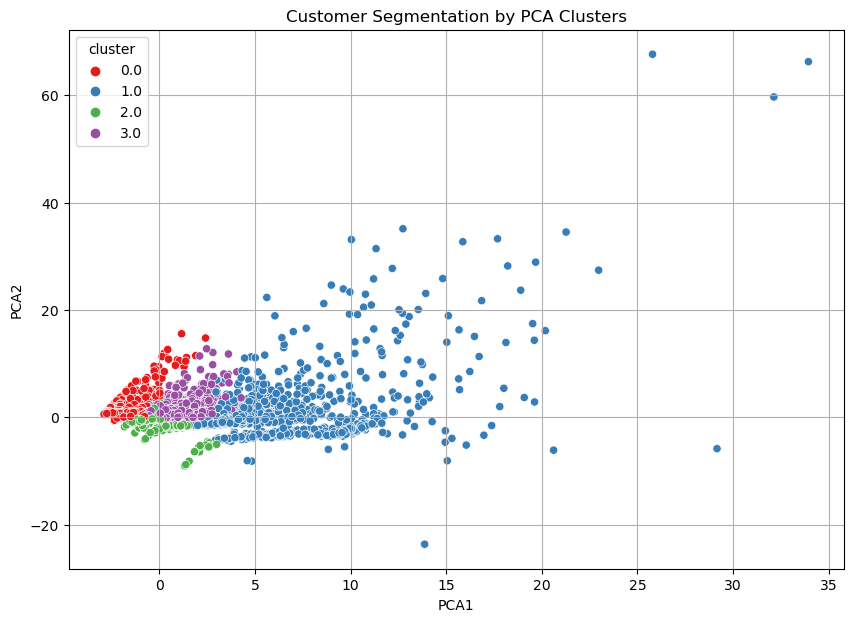

In [77]:
# === Step 7: Visualization ===
plt.figure(figsize=(10, 7))
sns.scatterplot(data=yearly_df, x='PCA1', y='PCA2', hue='cluster', palette='Set1')
plt.title('Customer Segmentation by PCA Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

In [78]:
# === Step 8: Cluster Profiling ===
cluster_profile = yearly_df.groupby('cluster')[[
    'yearly_volume', 'yearly_income', 'yearly_number_of_orders',
    'efficiency', 'total_cost','frequency'
]].mean().reset_index()

# Add cost-to-income ratio (%)
cluster_profile['cost_income_pct'] = (cluster_profile['total_cost'] / cluster_profile['yearly_income']) * 100

# Compute overall means for comparison
overall_means = yearly_df[[
    'yearly_volume', 'yearly_income', 'yearly_number_of_orders',
    'efficiency', 'total_cost','frequency'
]].mean().to_frame().T
overall_means['cluster'] = 'Overall Mean'
overall_means['cost_income_pct'] = (overall_means['total_cost'] / overall_means['yearly_income']) * 100

# Append overall means to cluster profile for comparison
cluster_profile = pd.concat([cluster_profile, overall_means], ignore_index=True)

print("Cluster Profiles with Enrichment:")
print(cluster_profile.to_markdown(index=False))

Cluster Profiles with Enrichment:
| cluster      |   yearly_volume |   yearly_income |   yearly_number_of_orders |   efficiency |   total_cost |   frequency |   cost_income_pct |
|:-------------|----------------:|----------------:|--------------------------:|-------------:|-------------:|------------:|------------------:|
| 0.0          |         1611.29 |         1202.04 |                   10.5855 |     1.40455  |      198.263 |     1.45427 |           16.4939 |
| 1.0          |        11697.1  |        11664.9  |                   49.3027 |     1.13621  |     1228.08  |     4.32132 |           10.5279 |
| 2.0          |         1770.07 |         1491.18 |                   12.9085 |     5.9761   |      598.702 |     1.78218 |           40.1496 |
| 3.0          |         5744.08 |         5376.24 |                   39.6677 |     0.409316 |      619.411 |     3.51179 |           11.5213 |
| Overall Mean |         4183.18 |         3875.19 |                   23.8371 |     2.25694  | 

In [79]:
cluster_counts = yearly_df['cluster'].value_counts(normalize=True) * 100
cluster_percentages = cluster_counts.round(2)

print("Percentage of each cluster:")
print(cluster_percentages)

Percentage of each cluster:
cluster
0.00   37.21
2.00   24.46
3.00   22.39
1.00   15.94
Name: proportion, dtype: float64


In [80]:
# === Step 9: Save Results to CSV ===
yearly_df.to_csv('customer_segmentation_with_clusters.csv', index=False)